# Amazon Review Data Analysis

## Import Data

In [ ]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd
from scipy import stats

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import os

In [ ]:
# import data
df = pd.read_csv("amazon-review-scraper.csv")
# view the data
df.head(5)

,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,verified,vote
0,1587446229-2237,https://www.amazon.com/OneOdio-Adapter-Free-He...,Amazon Customer,Great for mixing music,"Reviewed in the United States on January 7, 2020",I've been using the headphones for mixing my B...,5.0 out of 5 stars,Next page→,https://www.amazon.com/OneOdio-Adapter-Free-He...,Verified Purchase,NaN
1,1587446213-2168,https://www.amazon.com/OneOdio-Adapter-Free-He...,Zephyr,The sound is fantastic and they feel really we...,"Reviewed in the United States on May 1, 2018",The sound is fantastic and they feel really we...,5.0 out of 5 stars,Next page→,https://www.amazon.com/OneOdio-Adapter-Free-He...,Verified Purchase,2 people found this helpful
2,1587446189-2062,https://www.amazon.com/OneOdio-Adapter-Free-He...,Johnny B,"For the money the best I tried, and I tried......","Reviewed in the United States on October 5, 2019",For the price these are the best headphones I ...,5.0 out of 5 stars,Next page→,https://www.amazon.com/OneOdio-Adapter-Free-He...,Verified Purchase,NaN
3,1587446180-2027,https://www.amazon.com/OneOdio-Adapter-Free-He...,Ayah Seirafi,Awesome Customer Service!,"Reviewed in the United States on December 24, ...",I love these headphones! Big and noise-canceli...,5.0 out of 5 stars,Next page→,https://www.amazon.com/OneOdio-Adapter-Free-He...,Verified Purchase,NaN
4,1587446081-1617,https://www.amazon.com/OneOdio-Adapter-Free-He...,RRS,Worked well for a few weeks then just broke,"Reviewed in the United States on September 27,...","Worked fine, then after a few weeks I went to ...",1.0 out of 5 stars,Next page→,https://www.amazon.com/OneOdio-Adapter-Free-He...,Verified Purchase,One person found this helpful


## Data Cleaning

After an initial investigation of the data, we realized that the scraped reviews' order is messed up, and that is problematic for the rank. The web-scraper-order column represent the time stamp at which a review is scraped, so it should be representitive of ranking when sorted

### Order and Rank

In [ ]:
# need to properly order and rank the data
df_ordered = df.sort_values('web-scraper-order')
# evaluate with amazon product page review ranking
df_ordered.head(5)

,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,verified,vote
30,1587446039-1441,https://www.amazon.com/OneOdio-Adapter-Free-He...,Jet Mech 1,"Super ""bang-for-the buck""","Reviewed in the United States on June 4, 2018",This is an initial out-of-the box review:\nFir...,5.0 out of 5 stars,NaN,NaN,Verified Purchase,940 people found this helpful
731,1587446039-1442,https://www.amazon.com/OneOdio-Adapter-Free-He...,Sean,"Quality, High Fidelity, Comfortable, and a pri...","Reviewed in the United States on July 31, 2018",I bought these last year and let them sit on m...,5.0 out of 5 stars,NaN,NaN,Verified Purchase,315 people found this helpful
716,1587446039-1443,https://www.amazon.com/OneOdio-Adapter-Free-He...,David Diamond,"Clean, full sound with hearing compensation, a...","Reviewed in the United States on October 8, 2019",The OneOdio headphones have a very clean sound...,5.0 out of 5 stars,NaN,NaN,Verified Purchase,176 people found this helpful
643,1587446039-1444,https://www.amazon.com/OneOdio-Adapter-Free-He...,Ricardo Mera,Nice Product Awesome.,"Reviewed in the United States on December 8, 2017",Beginning with the sound it is spectacular the...,5.0 out of 5 stars,NaN,NaN,Verified Purchase,137 people found this helpful
357,1587446039-1445,https://www.amazon.com/OneOdio-Adapter-Free-He...,Darth Snoop,Great comfort and sound,"Reviewed in the United States on July 20, 2019",I just got these and will use them only with m...,5.0 out of 5 stars,NaN,NaN,Verified Purchase,83 people found this helpful


Now that the data is properly ordered, let's add the ranking column and clean up the unnecessary ones

In [ ]:
# add rank column
df_ranked = df_ordered.reset_index()
df_ranked['rank'] = range(1, len(df_ranked)+1, 1)
# get rid of unnecessary columns
uesless = ['index', 'web-scraper-order', 'web-scraper-start-url', 
           'author', 'next', 'next-href']
df_cleaned = df_ranked.drop(columns=uesless, axis=0)
# preview the ranked data
df_cleaned.head()

,title,date,content,rating,verified,vote,rank
0,"Super ""bang-for-the buck""","Reviewed in the United States on June 4, 2018",This is an initial out-of-the box review:\nFir...,5.0 out of 5 stars,Verified Purchase,940 people found this helpful,1
1,"Quality, High Fidelity, Comfortable, and a pri...","Reviewed in the United States on July 31, 2018",I bought these last year and let them sit on m...,5.0 out of 5 stars,Verified Purchase,315 people found this helpful,2
2,"Clean, full sound with hearing compensation, a...","Reviewed in the United States on October 8, 2019",The OneOdio headphones have a very clean sound...,5.0 out of 5 stars,Verified Purchase,176 people found this helpful,3
3,Nice Product Awesome.,"Reviewed in the United States on December 8, 2017",Beginning with the sound it is spectacular the...,5.0 out of 5 stars,Verified Purchase,137 people found this helpful,4
4,Great comfort and sound,"Reviewed in the United States on July 20, 2019",I just got these and will use them only with m...,5.0 out of 5 stars,Verified Purchase,83 people found this helpful,5


### Text Mining

In [ ]:
# extract each column as an array
title = df_cleaned['title']
dates = df_cleaned['date']
content = df_cleaned['content']
rating = df_cleaned['rating']
verified = df_cleaned['verified']
vote = df_cleaned['vote']
rank = df_cleaned['rank']

In [ ]:
# combine title and content as review feature
review = list()
for i in range(len(title)):
  review.append(title[i] + " " + content[i])
# check out the review content
review

['Super "bang-for-the buck" This is an initial out-of-the box review:\nFirst  off, what these headphones are. (40+ years of pro audio experience here).\nThese are an excellent Home Studio/Personal listening headphones. DJ quality? Well if your talking a weekend warrior occasional party DJ, then yeah. Professional/Commercial DJ use that subjects them to a lot of physical punishment, then absolutely not! Lets get real, they\'re $30.00 headphones.\nI give a positive 5 star for the following reasons: Sound quality to price point. I am hard pressed to tell any "real notable difference" between my high dollar studio grade Sennheiser or Bose headphone. These are also my first 50mm driver phones too. Here is my evaluated OPINION. Remember, all you really get on these reviews are just that, opinion.........\n\nTest 1. THX Sound System Check. Very accurate reproduction.\nTest 2. Bose Studio Demo CD. Very Good.\nMusic Tests:\n1. Also sprach Zarathustra, Op. 30-Richard Strauss; Excellent & Accurat

In [ ]:
# clean up the date format
import time
from datetime import date
from datetime import datetime
time = list()
for i in range(len(dates)):
  time.append(dates[i].replace('Reviewed in the United States on ', ''))
new_date = list()
input_format = "%B %d, %Y" # full month name, day and year
output_format = "%Y, %m, %d"
for t in time:
  nd = datetime.strptime(t, input_format).strftime(output_format)
  new_date.append(nd)
# converting string to datetime object
dt = [datetime.strptime(x, '%Y, %m, %d') for x in new_date]
today = date.today()
days_past = list()
# calculate how many days have passed since the posting
for i in range(len(new_date)):
  a = today
  b = datetime.date(dt[i])
  d = (a - b).days
  days_past.append(d)
len(days_past)

800

In [ ]:
# get the rating on a scale of 5
rating_score = list()
for r in rating:
  rating_score.append(float(r.split()[0]))
len(rating_score)

800

In [ ]:
# perform the same string operation on vote
helpful_vote = list()
for v in vote:
  if pd.isnull(v):
    helpful_vote.append(0)
  elif v == "One person found this helpful":
    helpful_vote.append(1)
  else:
    helpful_vote.append(int(v.split()[0]))
len(helpful_vote)

800

In [ ]:
# show that there are two levels to this variable
verified.unique() # ['Verified Purchase', 'VINE VOICE']
# encode the categorical variable verified
verified_purchase = list()
for v in verified:
  if v == 'Verified Purchase':
    verified_purchase.append(1)
  elif v == 'VINE VOICE':
    verified_purchase.append(2)
  else:
    verified_purchase.append(0)
len(verified_purchase)

800

In [ ]:
# compile the length of each review
review_length = list()
for r in review:
  review_length.append(len(r.split()))
len(review_length)

800

In [ ]:
# assign each review a sentiment score
from textblob import TextBlob
review_polarity = list()
review_subjectivity = list()
for r in review:
  blob = TextBlob(r)
  review_polarity.append((blob.sentiment.polarity + 1)/2)
  review_subjectivity.append(blob.sentiment.subjectivity)
len(review_polarity), len(review_subjectivity)

(800, 800)

In [ ]:
# create rank score, related to inverse rank
score = list()
for r in rank:
  score.append(np.log(801-r)*10)
len(score)

800

## Combining Data

In [ ]:
# combine the engineered attributes together
df_c = pd.DataFrame(np.column_stack([rank, review, review_length, review_polarity,
                                     review_subjectivity, days_past, rating_score, 
                                     helpful_vote, verified_purchase, score]), 
                               columns=['Rank', 'Review Text', 'Review Length', 
                                        'Review Polarity', 'Review Subjectivity',
                                        'Days Past', 'Rating', 'Helpful Vote',
                                        'Verified Purchase', 'Score'])

In [ ]:
df_c.head(20)

,Rank,Review Text,Review Length,Review Polarity,Review Subjectivity,Days Past,Rating,Helpful Vote,Verified Purchase,Score
0,1,"Super ""bang-for-the buck"" This is an initial o...",354,0.6363265467171717,0.5221359427609428,689,5.0,940,1,66.84611727667927
1,2,"Quality, High Fidelity, Comfortable, and a pri...",280,0.5693683862433863,0.49039682539682544,632,5.0,315,1,66.83360945766275
2,3,"Clean, full sound with hearing compensation, a...",377,0.5975,0.4268115942028986,198,5.0,176,1,66.82108597449809
3,4,Nice Product Awesome. Beginning with the sound...,55,0.8294444444444444,0.7600000000000001,867,5.0,137,1,66.80854678790215
4,5,Great comfort and sound I just got these and w...,104,0.7122727272727273,0.6318181818181818,278,5.0,83,1,66.79599185844383
5,6,Great Headphones I was looking for headphones ...,252,0.6014880952380952,0.5127112135176651,792,5.0,89,1,66.78342114654332
6,7,Great headphones... Great price Great cans for...,70,0.7625000000000001,0.511698717948718,55,5.0,50,1,66.77083461247136
7,8,Best in this price range Five stars “for the p...,298,0.5730044345898004,0.5831010452961672,872,5.0,70,1,66.75823221634847
8,9,One fabulous piece of comfort and engineering ...,215,0.6690476190476191,0.6435185185185185,493,5.0,47,1,66.74561391814426
9,10,"Pretty, pretty, pretty good I’m not going to s...",180,0.6625688705234161,0.5759641873278237,550,5.0,46,1,66.73297967767654


## Univariate Exploratory Analysis

In [ ]:
# Review Length
mu_rl = np.mean(review_length)
sd_rl = np.std(review_length)
mu_rl, sd_rl

(95.10625, 72.3609525983282)

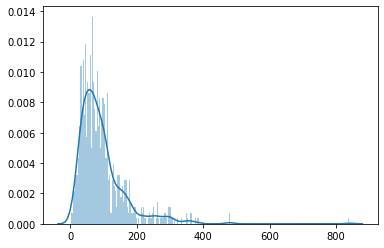

In [ ]:
sns.distplot(review_length, bins=240, hist=True)

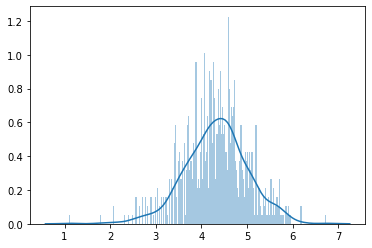

In [ ]:
sns.distplot(np.log(review_length), bins=240)

In [ ]:
# effects of review polarity on ranking
mu_rp = np.mean(review_polarity)
sd_rp = np.std(review_polarity)
mu_rp, sd_rp

(0.6397747638646649, 0.09487566149030321)

In [ ]:
# effects of review subjectivity on ranking
mu_rs = np.mean(review_subjectivity)
sd_rs = np.std(review_subjectivity)
mu_rs, sd_rs

(0.5615616226039619, 0.11541690270906083)

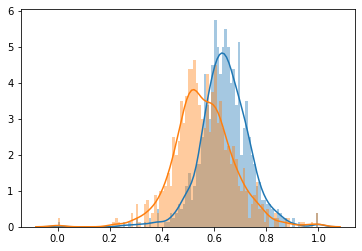

In [ ]:
sns.distplot(review_polarity, bins=100)
sns.distplot(review_subjectivity, bins=100)

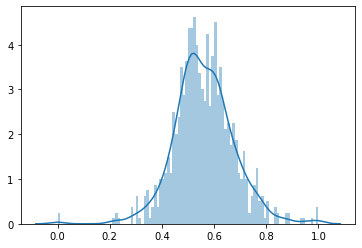

In [ ]:
sns.distplot(review_subjectivity, bins=100)

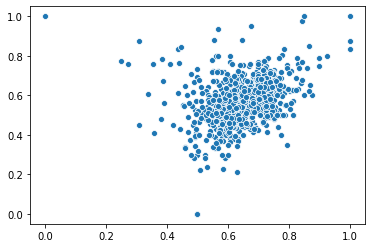

In [ ]:
sns.scatterplot(x=review_polarity, y=review_subjectivity)

In [ ]:
total_vote = np.sum(helpful_vote)
top50_vote = np.sum(helpful_vote[0:50])

In [ ]:
top50_vote/total_vote

0.7710843373493976

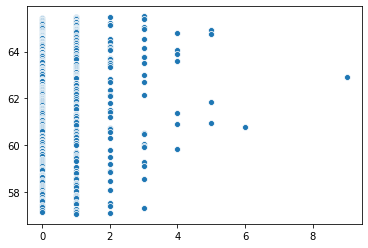

In [ ]:
sns.scatterplot(x=helpful_vote[100:500], y=score[100:500])

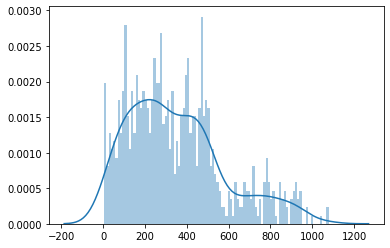

In [ ]:
sns.distplot(days_past, bins=100)

In [ ]:
review[6]

"Great headphones... Great price Great cans for the price... I work in radio and have found when I don't spend $100 on headphones they last longer but I still want good quality... These come with a convenient carrying bag and two cords... One regular 3.5 mm cord that you can plug into your phone, or a 6.35 jack for studio/dj use. Soft ear cushions and the noise canceling is great!"

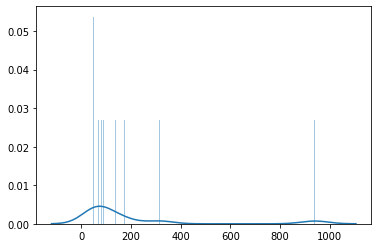

In [ ]:
sns.distplot(helpful_vote[0:10], bins=240, hist=True)

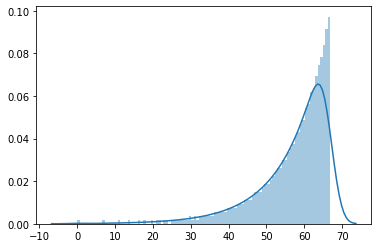

In [ ]:
sns.distplot(score, bins=100)

## Regression Analysis

In [ ]:
# normalize the important columns to be used
z_rl = stats.zscore(review_length)
z_rp = stats.zscore(review_polarity)
z_rs = stats.zscore(review_subjectivity)
z_dp = stats.zscore(days_past)
z_rs = stats.zscore(rating_score)
z_hv = stats.zscore(helpful_vote)

In [ ]:
df_z = pd.DataFrame(np.column_stack([z_rl, z_rp, z_rs, z_dp, z_rs, z_hv, score]), 
                               columns=['Review Length', 'Review Polarity', 
                                        'Review Subjectivity', 'Days Past', 
                                        'Rating', 'Helpful Vote', 'Score'])

In [ ]:
# get the data and label
df_t = df_z.drop(labels = ['Score'], axis=1)
df_l = df_z[['Score']]

In [ ]:
# normalize every column in the data
X = df_t.to_numpy(dtype='float')
y = df_l.to_numpy(dtype='float')

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
# X = sm.add_constant(X.ravel())
results = sm.OLS(y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.034
Date:                Thu, 23 Apr 2020   Prob (F-statistic):                       0.396
Time:                        19:24:30   Log-Likelihood:                         -4377.3
No. Observations:                 800   AIC:                                      8765.
Df Residuals:                     795   BIC:                                      8788.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.6300      2.182      2.122      0.034       0.347       8.913
x2            -0.1628      2.404     -0.068      0.946      -4.882       4.556
x3            -0.4468      1.192     -0.375      0.708      -2.787       1.894
x4             0.2994      2.061      0.145      0.885      -3.746       4.345
x5            -0.4468      1.192     -0.375      0.708      -2.787       1.894
x6            -0.1273      2.088     -0.061      0.951      -4.227       3.972
==============================================================================
Omnibus:                      348.450   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1561.516
Skew:                          -2.018   Prob(JB):                         0.00
Kurtosis:                       8.528   Cond. No.                     3.01e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.07e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# fit the random forest model
# n_estimators is 500 and max_features is 7 as corresponding to R n and mtry
rfc = RandomForestRegressor(random_state=42)
model = rfc.fit(X, y)
# build and rank all features importance in this classifier
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature ranking:
1. feature 0 (0.513564)
2. feature 3 (0.195459)
3. feature 1 (0.161767)
4. feature 5 (0.083815)
5. feature 4 (0.022926)
6. feature 2 (0.022469)


'Review Length'(feature 0), 'Review Polarity' (feature 1), 'Review Subjectivity'(feature 2), 'Days Past' (feature 3), 'Rating'(feature 4), 'Helpful Vote' (feature 5), Verified (Omitted because all equal to 1)

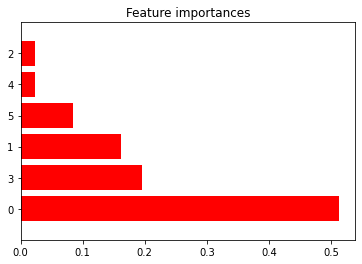

In [ ]:
# plot the feature importance
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

## Create Equation

$ Review Score = \frac{UserCredibilityMetric(k)*Intrinsic Value(\beta_1 Review Length + \beta_2 helpfulness + \beta_3 Sentiment) + \beta_4 * image + \beta_5 Verification}{Time Decay Value} $